In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from palettable.colorbrewer.sequential import GnBu_9

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/32999/status,
Dashboard: /proxy/32999/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46765,Workers: 4
Dashboard: /proxy/32999/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:32787,Total threads: 4
Dashboard: /proxy/39515/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:40937,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'cmip6', 'reanalysis']

In [7]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_lin = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

Load reanalysis and CMIP6 multimodel mean

In [13]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].mean('time')
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].mean('time')
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl'].mean('time')

In [5]:
wsp = {}
for k in keys:
    wsp[k] = np.sqrt(uas[k]**2 + vas[k]**2)

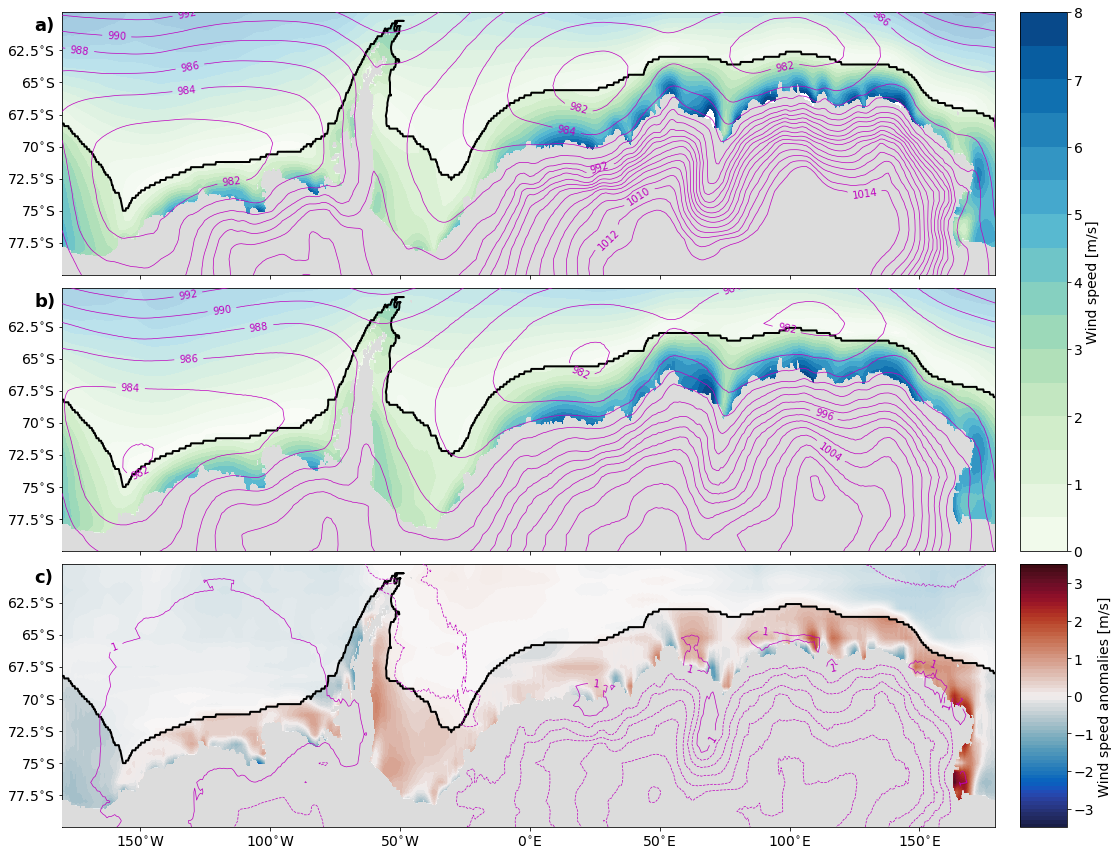

In [8]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 15))
gr = gs.GridSpec(3, 2, figure = fig, width_ratios = [1, .05], hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[:2,1]), 
       fig.add_subplot(gr[2,1])]
for ax, label in zip(axs[:-2], ['a)', 'b)', 'c)']):
    ax.text(-0.03, .93, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
                  vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)
    
# Reanalysis
c = axs[0].contourf(wsp['reanalysis']['lon'], wsp['reanalysis']['lat'], wsp['reanalysis'], levels = np.arange(0, 8.5, .5), 
                    cmap = GnBu_9.mpl_colormap, zorder = 0)
fig.colorbar(c, cax = axs[-2]).set_label('Wind speed [m/s]')
c = axs[0].contour(psl['reanalysis']['lon'], psl['reanalysis']['lat'], psl['reanalysis']/100,
                   levels = np.arange(0, 1015, 2), colors = ['m'], linewidths = [0.7], zorder = 4)
ax.clabel(c, c.levels, inline=True, fmt='%1.0f', fontsize=10)
# CMIP6
c = axs[1].contourf(wsp['cmip6']['lon'], wsp['cmip6']['lat'], wsp['cmip6'], levels = np.arange(0, 8.5, .5), 
                    cmap = GnBu_9.mpl_colormap, zorder = 0)
c = axs[1].contour(psl['cmip6']['lon'], psl['cmip6']['lat'], psl['cmip6']/100,
               levels = np.arange(0, 1015, 2), colors = ['m'], linewidths = [0.7], zorder = 4)
ax.clabel(c, c.levels, inline = True, fmt='%1.0f', fontsize=10)
# CMIP6 anomalies
c = axs[2].contourf(wsp['cmip6']['lon'], wsp['cmip6']['lat'], wsp['cmip6']-wsp['reanalysis'], levels = np.arange(-3.5, 3.6, .1), 
                    cmap = cmocean.cm.balance, zorder = 0)
cbar = fig.colorbar(c, cax = axs[-1])
cbar.set_ticks(np.arange(-3, 4, 1))
cbar.set_label('Wind speed anomalies [m/s]')
c = axs[2].contour(psl['cmip6']['lon'], psl['cmip6']['lat'], psl['cmip6']/100-psl['reanalysis']/100,
                   levels = np.arange(-11, 13, 2), colors = ['m'], linewidths = [0.7], zorder = 4)
ax.clabel(c, c.levels, inline = True, fmt='%1.0f', fontsize=10)

plt.savefig('../results/v5/fig1.jpg', bbox_inches = 'tight')

# Supplementary

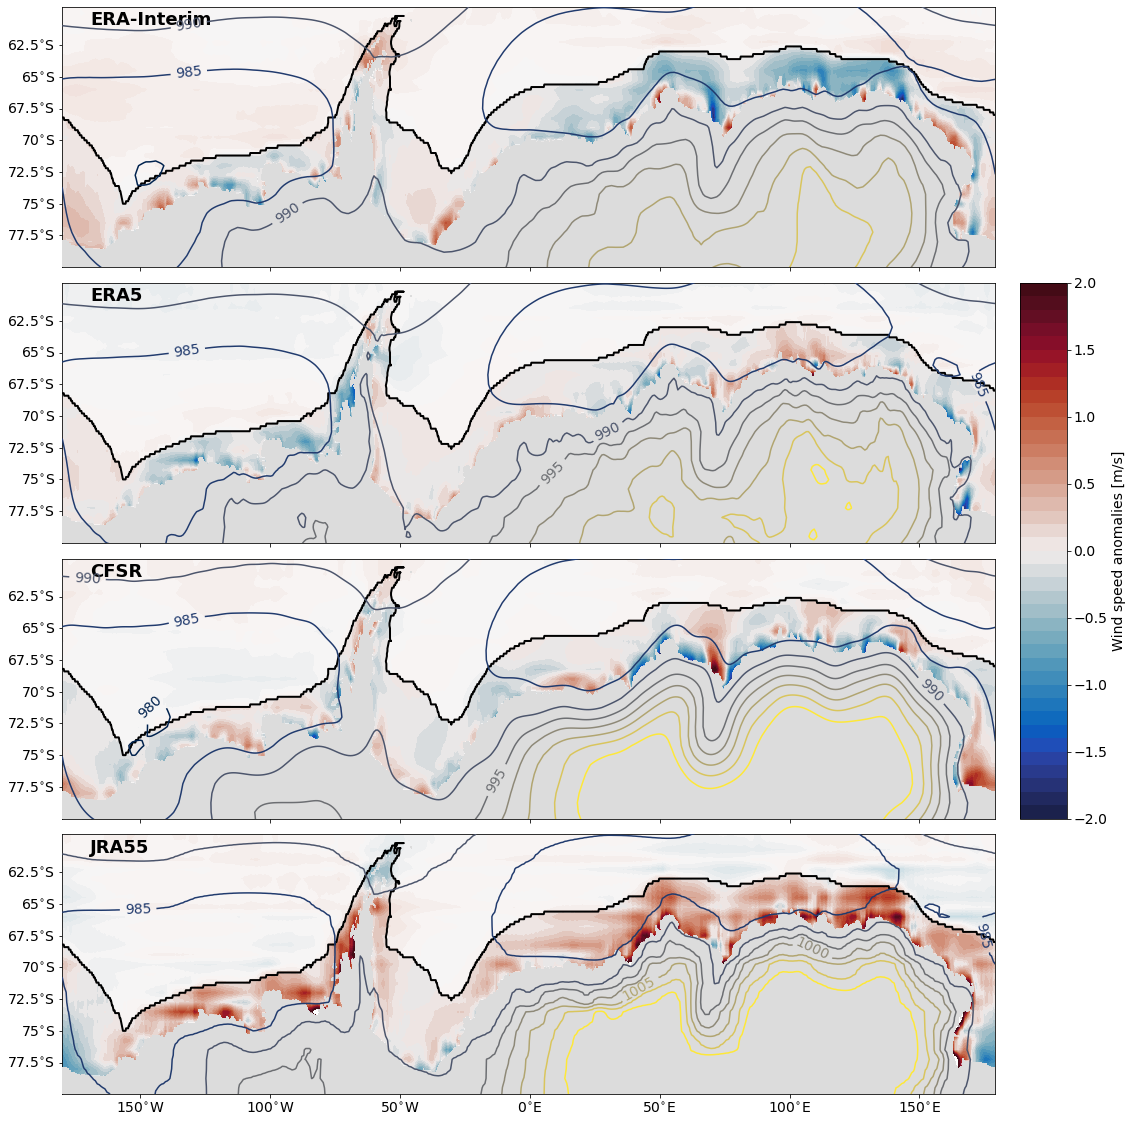

In [14]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
for ax, label in zip(axs[:-1], ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']):
    ax.text(0.03, .93, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
                  vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)

    n = 0
for k in keys[:-2]:
    cf = axs[n].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k]-wsp['reanalysis'],
                        levels = np.arange(-2, 2.1, .1), cmap = cmocean.cm.balance)
    cc = axs[n].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100, levels = np.arange(980, 1020, 5),
                        cmap = 'cividis', zorder = 4)
    axs[n].clabel(cc, cc.levels, inline = True, fmt='%1.0f', fontsize=14)
    n += 1
    
fig.colorbar(cf, cax = axs[-1]).set_label('Wind speed anomalies [m/s]')

plt.savefig('../results/v5/figsup1.jpg', bbox_inches = 'tight')

Load CMIP6 individual models

In [37]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
path_psl = glob.glob('../data/cmip6-regridded/psl_hist*')
uas_cmip = {}; vas_cmip = {}; psl_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
    
    model_name = path_psl[i].split('/')[-1].split('_')[-1].split('.')[0]
    psl_cmip[model_name] = xr.open_dataset(path_psl[i]).sel(time = slice('1979-01-01', '2015-01-01'))['psl']
model_keys = list(uas_cmip.keys())

In [38]:
wsp_cmip6 = {}
for k in model_keys:
    wsp_cmip6[k] = np.sqrt(uas_cmip[k]**2+vas_cmip[k]**2).mean('time')

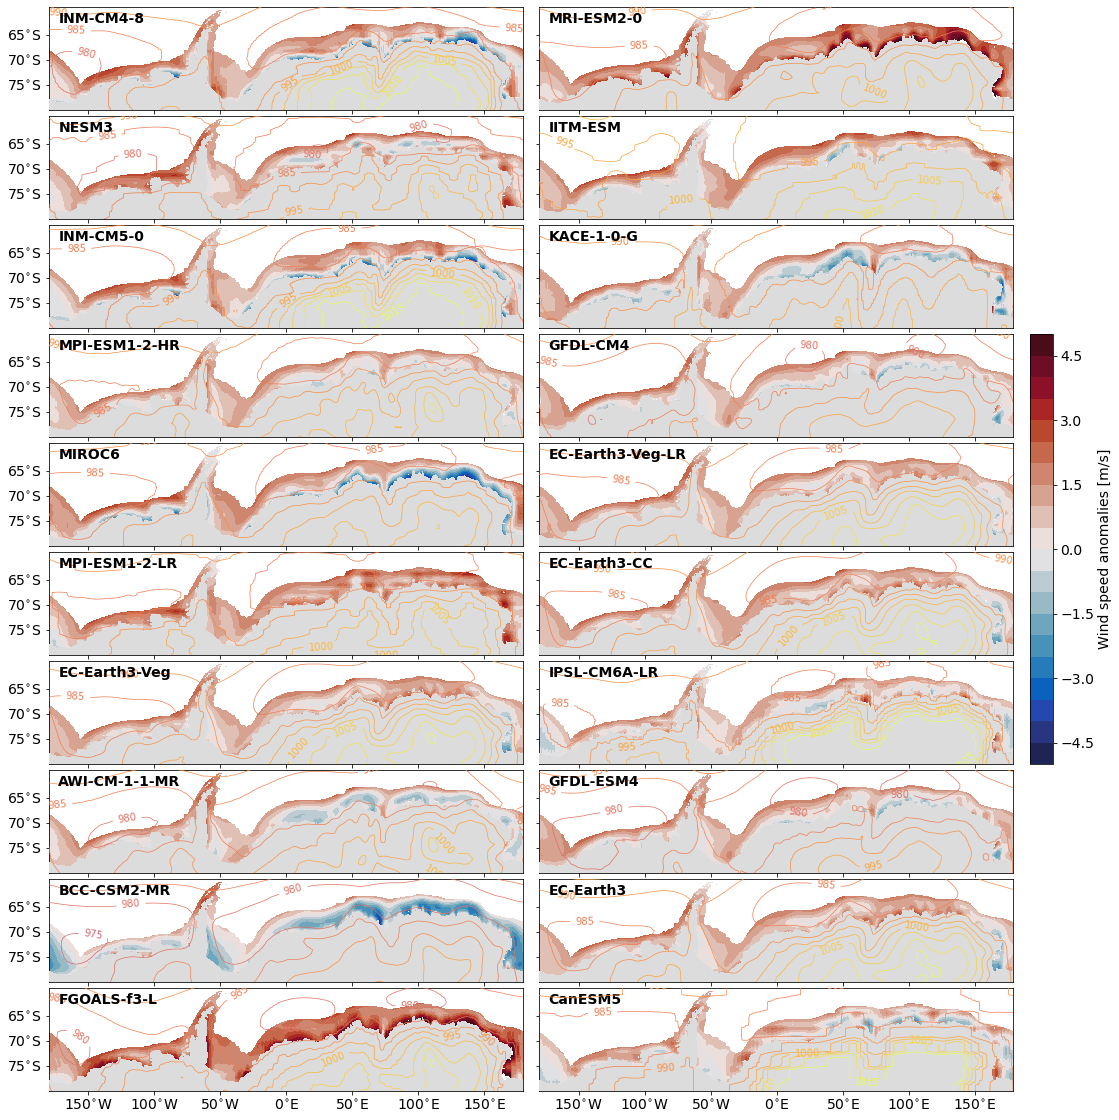

In [69]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 40))
gr = gs.GridSpec(20, 3, figure = fig, width_ratios = [1,1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), 
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]),
       fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), 
       fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]),
       fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), 
       fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]),
       fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0]), 
       fig.add_subplot(gr[9,1]),
       fig.add_subplot(gr[3:7,2])]
for ax, label in zip(axs[:-1], model_keys):
    #ax.text(0.02, .85, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-75, -60,5))
    if ax in [axs[0], axs[2], axs[4], axs[6], axs[8], axs[10], axs[10], axs[12], axs[14], axs[16], axs[18], axs[20]]:
        ax.set_yticklabels(['75$^{\circ}$S', '70$^{\circ}$S', '65$^{\circ}$S'])
    else:
        ax.set_yticklabels([])
    if ax in axs[:2]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, 
                  cmap = 'binary', zorder = 2)
    
n = 0
for k in model_keys:
    ax.text(0.02, .85, k, transform = axs[n].transAxes, size = 14, weight = 'bold')
    cf = axs[n].contourf(wsp_cmip6[k]['lon'], wsp_cmip6[k]['lat'], wsp_cmip6[k]-wsp['cmip6'], levels = np.arange(-5, 5.5, .5), 
                        cmap = cmocean.cm.balance)
    cc = axs[n].contour(psl_cmip[k]['lon'], psl_cmip[k]['lat'], psl_cmip[k].mean('time')/100, levels = np.arange(920, 1020, 5),
                        cmap = cmocean.cm.thermal, linewidths = [0.7], zorder = 4)
    axs[n].clabel(cc, cc.levels, inline = True, fmt='%1.0f', fontsize=10)
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Wind speed anomalies [m/s]')
plt.savefig('../results/v5/figsup2.jpg', bbox_inches = 'tight')

Do vertical levels vs. model bias

In [79]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

In [9]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
    v_ave[k] = (vas[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
for k in model_names:
    u_ave[k] = (uas_cmip[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
    v_ave[k] = (vas_cmip[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))

In [75]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai']))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [83]:
wsp_avg_ensmean = (wsp['cmip6']*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat')).sum('lon')

In [88]:
wsp_bias = (wsp_cmip6[model_keys[0]]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat')).sum('lon')
for k in model_keys[1:]:
    wsp_bias = xr.concat([wsp_bias, (wsp_cmip6[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat')).sum('lon')], dim = 'model')
wsp_bias['model'] = model_keys

In [90]:
ver_levs = xr.DataArray([95, 45, 49, 91, 91, 91, 62, 32, 33, 49, 64, 21, 73, 79, 85, 81, 95, 47, 80, 47], dims = 'model', coords = {'model':np.sort(model_keys)})

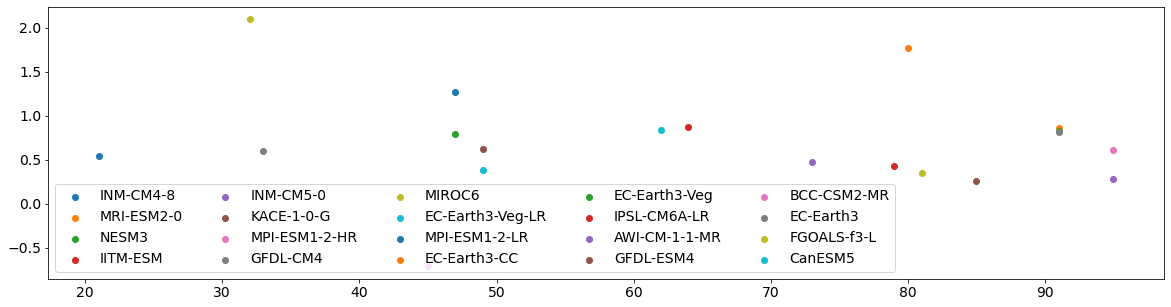

In [101]:
plt.figure(figsize = (20,5))
for k in model_keys:
    plt.scatter(ver_levs.sel(model=k), wsp_bias.sel(model=k)-wsp_avg_ensmean, label = k)
plt.legend(ncol = 5)

In [102]:
from scipy import stats as st

In [103]:
st.linregress(ver_levs.values, wsp_bias.values)

LinregressResult(slope=-0.006184333476716877, intercept=4.187247890147977, rvalue=-0.25372808785679535, pvalue=0.28039531583800326, stderr=0.005556973512752107, intercept_stderr=0.38577565151589394)